# Cumulative Stock Performace of Glassdoor's Top-rated Companies

the website [Glassdoor.com](https://www.glassdoor.com/index.htm) publishes an annual listing of top rated companies as reviewed by employees [[Link]](https://www.glassdoor.com/Award/Best-Places-to-Work-LST_KQ0,19.htm). I was curious to see if the stock of these companies compared to the broader market overall. Do they outperform the market? What kind of companies are more likely to make the list? This notebook was created to find out the answers to these questions. It is divided into two main sections: 
1. **Data Collection:** Data will be collected using various methods, including manual collection, and making use of API's and 3rd party libraries. The glassdoor ratings for top 20 companies of years 2009-2021 were collected manually into a CSV file. Additional data to be collected includes stock tickers, sector classification, and stock price history.
2. **Data Analysis:** Once sufficient data is collected, it will be collated into a dataframe (tabular format). Custom-made functions will parse the dataframe to then collect stock history information for each of the top rated companies and create an portfolio/index of average stock performance of the companies for each year. This metric will then be compared to the performance of the S&P 500 index for the same year. The results will be calculated, compared, and output to screen.

This project was made using Python3 programming language and primarily used the Pandas data science package. Other libraries used include yfinance to obtain stock information, requests to connect to Yahoo Finance API, and matplotlib to create visualizations.

## Required Python Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Markdown, display

## Part 1: Data Collection

First I manually collected data for years 2009-2021 from the Glassdoor website into a csv file. The data was organized into three columns:
- **year**: Year of rating
- **ranking**: Ranking of company based on reviews
- **company_name**: Name of company

See preview below:

In [2]:
# Import the dataset into a dataframe
df = pd.read_csv('glasdoor_yearly_bestplacestowork.csv')
# Preview the dataframe
df.head()

,year,ranking,company_name
0,2009,1,nvidia
1,2009,2,hubspot
2,2009,3,bain & company
3,2009,4,exp realty
4,2009,5,box


I collected the 20 top rated companies for each year but we will limit our analysis to the top 18 companies for each year. 

*Note: This reduction is arbitrary and was done due to cap the amount of API calls needed to be done later in the data collection process as I am utilizing a free tier API which limits amount of calls*

In [3]:
# Filter dataframe to top 18 companies for each year
df = df[df['ranking'] <= 18]

### Obtaining Stock Ticker Symbols

In order to proceed with evaluating stock performance, we will need to collect additional information inclusing the stock tickers for each of the companies in the dataframe (if they are publicly traded). A **stock ticker** is a unique identifier consisting of a series of letters assigned to a security for trading purposes. Example: Apple.Inc's stock ticker is "AAPL".

Here, a custom function will be created to use Yahoo Finance's API to query the company names in our dataset against the Yahoo Finance database and return resulting stock ticker. 

In [4]:
def get_stock_ticker(search_term):
    '''
    Function will take a company name (str) as argument and using yfinance API, search for and return a ticker name.
    Returns: Stock market ticker symbol or 'N/A' if not found
    '''
    # intialize empty list, will contain results if found
    results = []
    # Compose query and assign response to "response" variable
    query = requests.get(f'https://yfapi.net/v6/finance/autocomplete?region=IN&lang=en&query={search_term}', 
    headers={
        'accept': 'application/json',
        'X-API-KEY': 'xxxxxxxxxxxxxxxxx'
    })
    response = query.json()
    for i in response['ResultSet']['Result']:
        final = i['symbol']
        results.append(final)
    try:
        ticker = results[0]
        return ticker
    except IndexError: 
        # If not found, will cause index error. Return 'N/A' in this case
        return 'N/A'

In [5]:
# Obtain a listing of unique company names and assign to new dataframe "tckr_df"
tckr_df = pd.DataFrame(df['company_name'].unique(), columns= ['company_name'])

In [6]:
# Apply "get_stock_ticker" function to new dataframe "tckr_df"
tckr_df['stock_ticker'] = tckr_df['company_name'].apply(get_stock_ticker)
# Show first 10 rows of dataframe
tckr_df.head(10)

,company_name,stock_ticker
0,nvidia,NVDA
1,hubspot,HUBS
2,bain & company,BCSF
3,exp realty,N/A
4,box,BOX
5,boston consulting group,N/A
6,google,GOOG
7,veterans united home loans,N/A
8,lululemon,LULU
9,salesforce,CRM


We now have a table of unique company names and their corresponding stock tickers (if any). Let's take a closer look at the companies for which the function did NOT yield any stock tickers:

In [7]:
# Filter "tckr_df" to show companies with no stock ticker found indicated by "N/A"
tckr_df[tckr_df['stock_ticker'] == 'N/A'].reset_index(drop=True)

,company_name,stock_ticker
0,exp realty,N/A
1,boston consulting group,N/A
2,veterans united home loans,N/A
3,nasa jet propulsion laboratory,N/A
4,johns hopkins university applied physics labor...,N/A
5,slalom,N/A
6,mckinsey & company,N/A
7,northwestern mutual,N/A
8,kraft foods,N/A
9,edelman,N/A


Additional research of these companies show that the majority of these are mostly privately owned and thus do not issue stock. We will drop these companies from the dataset.

In [8]:
# Drop "N/A" values (The function was unable to find a stock ticker)
tckr_df = tckr_df[tckr_df['stock_ticker'] != 'N/A']
# Reset index
tckr_df = tckr_df.reset_index(drop=True)

### Obtaining Sector & Currency Type 
To supplement the analysis we will collect information on sector type. a **sector** is an industry group used to categorize the economic activity of consumers and businesses [[Link]](https://www.investopedia.com/terms/s/sector.asp). We will use the yfinance python library to compose another custom function that will be used to identify what sector each of these companies can be categorized into. Yfinance is an Open-Source Python library developed by Ran Aroussi as a means to access the financial data available on Yahoo Finance [[Link]](https://github.com/ranaroussi/yfinance). We will also use it to collect currency type as I am only interested in evaluating the american stock market (USD).

Examples of sector types:
- Technology
- Energy
- Financial Services

In [9]:
# Function to get sector and currency type
def get_stock_nfo(ticker_symbol):
    '''
    Function will take a stock ticker symbol (str) as argument. 
    Returns: Sector type using yfinance library .info method
    '''
    try:
        # Use yfinance .info method to get sector type
        stock = yf.Ticker(ticker_symbol) 
        sector_ = stock.info['sector']
        currency = stock.info['currency']
        #return pd.Series([sector_, currency], index=['sector', 'currency'])
        return [sector_, currency]
    except:
        # If not found or in case of error return "N/A"
        return 'N/A'

In [10]:
# Apply the function to the "stock_ticker" column in "tckr_df" dataframe
tckr_df['values'] = tckr_df['stock_ticker'].apply(get_stock_nfo)

In [11]:
# Review null values
tckr_df[tckr_df['values']=='N/A']

,company_name,stock_ticker,values
7,royal caribbean group,RC8.SG,N/A
24,overstock.com,OVER.BE,N/A
25,rei,^REI,N/A


The yfinance library was unable to retrieve information for the above stocks. These will be dropped from the dataset.

In [12]:
# drop null values
tckr_df = tckr_df[tckr_df['values']!='N/A'].reset_index(drop=True)

We will split *values* column which contains a list of sector and currency information into two distinct columns of each type:

In [13]:
# new df from the column of lists
split_df = pd.DataFrame(tckr_df['values'].tolist(), columns=['sector', 'currency'])
# concat df and split_df
tckr_df = pd.concat([tckr_df, split_df], axis=1)
# Drop value column
tckr_df = tckr_df.drop(columns=['values'])
# display df
tckr_df.head()

,company_name,stock_ticker,sector,currency
0,nvidia,NVDA,Technology,USD
1,hubspot,HUBS,Technology,USD
2,bain & company,BCSF,Financial Services,USD
3,box,BOX,Technology,USD
4,google,GOOG,Communication Services,USD


In [14]:
# Review non-USD stocks
tckr_df[tckr_df['currency']!='USD']

,company_name,stock_ticker,sector,currency
14,mitre,MTRE3.SA,Real Estate,BRL


For the purpose of this analysis, we will remove stocks not in USD.

In [15]:
# Keep only USD currency stocks
tckr_df = tckr_df[tckr_df['currency']=='USD'].reset_index(drop=True)

### Merging Dataframes
Now that we have obtained relevant data on stock tickers and additional information, we will merge the *tckr_df* dataframe to our original *df* dataframe containing the rankings from Glassdoor. Note that this merge will drop rows (companies) that are not existing in the *tckr_df* dataframe so only the publicly traded companies for which we were able to collect stock ticker and sector classification data will remain.

In [16]:
# Merge dataframes
merged_df = pd.merge(df, tckr_df, on='company_name')
# Restore original sort order
merged_df = merged_df.sort_values(['year', 'ranking'], ascending=[True, True])
# Reset index
merged_df = merged_df.reset_index(drop=True)
# show first 10 rows of resulting dataframe:
merged_df.head(10)

,year,ranking,company_name,stock_ticker,sector,currency
0,2009,1,nvidia,NVDA,Technology,USD
1,2009,2,hubspot,HUBS,Technology,USD
2,2009,3,bain & company,BCSF,Financial Services,USD
3,2009,5,box,BOX,Technology,USD
4,2009,7,google,GOOG,Communication Services,USD
5,2009,9,lululemon,LULU,Consumer Cyclical,USD
6,2009,10,salesforce,CRM,Technology,USD
7,2009,13,five9,FIVN,Technology,USD
8,2009,14,twilio,TWLO,Communication Services,USD
9,2009,16,adobe,ADBE,Technology,USD


### Retreiving Stock Price History
Below, is a custom-made function which will use the yfinance library to retrieve a series of closing stock prices for a given stock during a given year. Stock ticker and year will be the arguments of the function.

In [17]:
# Get a series of stock closing prices using yfinance
def daily_closing_prices(symbol, year):
    '''
    Function uses yfinance to return series of daily stock closing prices. Arguments (str): Stock symbol and year. 
    '''
    try:
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=f'{year}-01-01', end=f'{year}-12-30', interval='1d')
        close_price = data['Close']
        return close_price.dropna()
    except Exception as e:
        print("Failed to get required data.", e)

Below is a custom-made function that will get a series of dates for a given year from the yfinance library. Stocks only trade on non-holiday weekdays. Luckily yfinance already provides date information in the index of the .history method used in the function above. Therefore will be simple to extract a series of trading dates from result of above *daily_closing_prices* function. in this case we will use MSFT as an example to do this.

In [18]:
# get a series of dates in year using yfinance
def get_dates_year(year):
    '''
    Function uses yfinance to return series of trading dates in given year. Arguments (str): Year. 
    '''
    sample = daily_closing_prices('MSFT', year)
    dates_df = pd.DataFrame({'date': sample.index})
    return dates_df

## Part 2: Data Analysis


### Top Rated Companies by Sector
Reviewing what concentrations of sectors (if any) exist for this dataset.

In [19]:
# Create a series of value counts by sector type
s = merged_df['sector'].value_counts()
# Create a DataFrame using above Series
freq_df = pd.DataFrame({'sector': s.index, 'count': s.values})
# Calculate percentage of total
freq_df['percentage_of_total'] = round((freq_df['count']/freq_df['count'].sum())*100,2)
# View dataframe
freq_df

,sector,count,percentage_of_total
0,Technology,47,38.21
1,Communication Services,25,20.33
2,Financial Services,16,13.01
3,Industrials,13,10.57
4,Consumer Defensive,8,6.50
5,Consumer Cyclical,6,4.88
6,Energy,5,4.07
7,Healthcare,2,1.63
8,Basic Materials,1,0.81


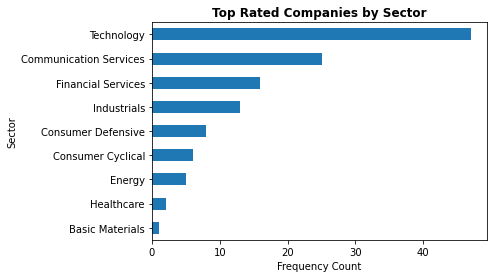

In [20]:
# Create Visualization
ax = merged_df['sector'].value_counts().plot.barh()
ax.invert_yaxis()
plt.title('Top Rated Companies by Sector', fontweight = 'bold')
plt.xlabel('Frequency Count')
plt.ylabel('Sector')
plt.show()

The majority of the top ranked companies in the annual ratings are *Technology* companies. This is followed by *Communication Services* and *Financial Services*.

### Recurring Top Rated Companies 
Some companies are repeatedly ranked highly for multiple years:

In [21]:
# Create a series of value counts by sector type
s = merged_df['company_name'].value_counts()
# Create a DataFrame using above Series
freq_df = pd.DataFrame({'company_name': s.index, 'year_count': s.values})
# View top 10 results
freq_df.head(10)

,company_name,year_count
0,bain & company,13
1,google,12
2,facebook,10
3,southwest airlines,7
4,hubspot,6
5,salesforce,6
6,lululemon,4
7,chevron,4
8,adobe,3
9,general mills,3


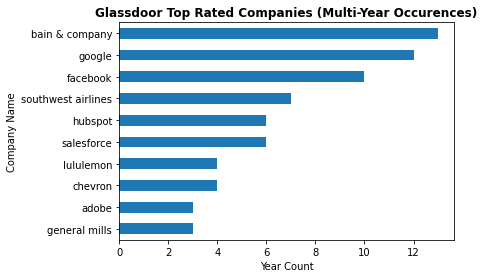

In [22]:
# Create Visualization
ax = merged_df['company_name'].value_counts().head(10).plot.barh()
ax.invert_yaxis()
plt.title('Glassdoor Top Rated Companies (Multi-Year Occurences)', fontweight = 'bold')
plt.xlabel('Year Count')
plt.ylabel('Company Name')
plt.show()

Bain and Company, Google, and Facebook in particular are companies that are repeatedly making the list of top rated companies for multiple years.

### Calculating Stock Performance

To proceed to evaluate stock performance the below function, *gen_perf_df*, will generate dataframes of stock performace metrics for any given year in the dataset when provided as an argument. Also collected will be performance metrics of Vanguard's S&P 500 ETF, VOO, for that same year to compare the glassdoor companies against the S&P 500 index.

In [23]:
def gen_perf_df(year):
    # Initialize dataframe with dates
    daily_perf_df = get_dates_year(year)
    # Get stock tickers for year
    stock_tickers = merged_df[merged_df['year'] == int(year)]['stock_ticker'].unique()
    # Iterate over individual stock tickers
    for stock in stock_tickers:
        try:
            # Obtain daily closing prices of stock using yfinance
            prices_close = daily_closing_prices(stock, year)
            # Extract closing values and append as new column to "daily_perf_df" dataframe
            daily_perf_df[stock] = prices_close.values
        except:
            # In case of error fill column with NaN values
            daily_perf_df[stock] = np.nan
    # Drop columns containing null values
    null_cols = [col for col in daily_perf_df.columns if daily_perf_df[col].isnull().any()]
    if null_cols:
        daily_perf_df = daily_perf_df.drop(columns = null_cols)
    # Iterate over columns
    for col in daily_perf_df.columns:
        # Columns containing stock tickers are uppercase
        if col.isupper():
            # Convert numbers to percentage differences
            daily_perf_df[col] = daily_perf_df[col].pct_change()
    # Fill null values with column mean
    daily_perf_df = daily_perf_df.fillna(daily_perf_df.mean(numeric_only=True))
    # Calculate mean percentage change for each row from 2nd col through last (1st col is date range)
    daily_perf_df['mean'] = daily_perf_df.iloc[:, 1:].mean(axis=1)
    try:
        # function to calculate compounding daily balance of hypothetical portfolio 
        def invest_1k(iterable):
            # Starting portfolio value
            portfolio_balance = 1000
            # Initialize list of daily portfolio balances
            daily_balances = []
            for pct_change in iterable:
                daily_return = portfolio_balance * pct_change
                portfolio_balance = portfolio_balance + daily_return
                daily_balances.append(portfolio_balance)   
            return daily_balances
        # Calculate hypothetical portfolio returns of average of glassdoor companies and add to dataframe
        daily_perf_df['portfolio_balance_glassdoor'] = invest_1k(daily_perf_df['mean'].values)
        # Get daily closing prices for S&P 500 using VOO ETF
        daily_perf_df['VOO'] = daily_closing_prices('VOO', year).values
        # Convert to percentage changes
        daily_perf_df['VOO'] = daily_perf_df['VOO'].pct_change()
        # Fill null values with column mean
        daily_perf_df = daily_perf_df.fillna(daily_perf_df.mean(numeric_only=True))  
        # Calculate hypothetical portfolio returns of VOO and add to dataframe
        daily_perf_df['portfolio_balance_s&p500'] = invest_1k(daily_perf_df['VOO'].values)
    except:
        print('Warning: Unable to retrieve information for VOO')
        pass 
    return daily_perf_df

We will also create a function that will take the dataframe generated by above function as an argument to then visualize the stock performance for the year in a line graph.

In [24]:
# Data Visualization
def gen_chart(df):
    # For formatting month axis
    month_locator = mdates.MonthLocator(interval=1)
    year_month_formatter = mdates.DateFormatter("%m-%Y") # four digits for year, two for month
    # Setting plotting params
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.xaxis.set_major_locator(month_locator) 
    ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
    # Plot
    try:
        ax.plot(df['date'], df['portfolio_balance_glassdoor'], label = 'Glassdoor Portfolio')
        ax.plot(df['date'], df['portfolio_balance_s&p500'], label = 'S&P 500 Index (VOO) Portfolio')
    except KeyError as e:
        print('Warning: Was unable to retrieve information for VOO. This ETF was established in 2010!')
        pass
    plt.title(f'Performace of $1,000 Invested ({year})', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Balance (Dollars)')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.grid(color = 'darkgray', linestyle = '--', linewidth = 0.5)
    plt.show()

Other miscallenous functions to be used later:

In [25]:
# Print text in markdown formatting
def printmd(string):
    display(Markdown(string))

# Function to calculate percentage change between 2 numbers
def get_pct_change(previous, current):
    if current == previous:
        return 100.00
    try:
        pct = ((current - previous) / previous) * 100.0
        return round(pct,2)
    except ZeroDivisionError:
        return 0
    
# Function to return proper descriptive verb when given a percentage
def verb(num):
    return 'fell' if num < 0 else'grew'

## Results
The *gen_perf_df* and *gen_chart* functions can now be utilized to generate a markdown-formatted report of performance metrics for each year in the dataset. 

For each year for which we are able to collect stock history information on at least 5 of the top-rated glassdoor companies, the following metrics will be shown:
- **Warning messages:** Any output containing information about any shortcomings of the data/analysis.
- **Visualization:** A line graph of portfolio performance for given year
- **Stocks List:** A list of stocks which compose the portfolio for given year
    - Portfolio assumes $1,000 equally invested amongst the stocks and for comparison, equvalent amount invested in VOO ETF (tracks the S&P 500).
- **Results Summary:** A sentence describing stock performance for given year. Will compare it to S&P 500 index (if avialable)

**Stock Performance Calculations for 2009:**

- HUBS: Data doesn't exist for startDate = 1230796800, endDate = 1262160000
- BCSF: Data doesn't exist for startDate = 1230796800, endDate = 1262160000
- BOX: Data doesn't exist for startDate = 1230796800, endDate = 1262160000
- FIVN: Data doesn't exist for startDate = 1230796800, endDate = 1262160000
- TWLO: Data doesn't exist for startDate = 1230796800, endDate = 1262160000
- VOO: Data doesn't exist for startDate = 1230796800, endDate = 1262160000


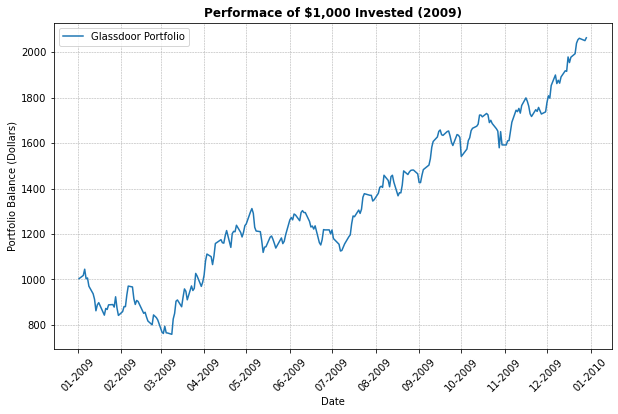

Stocks in 2009 Glassdoor Portfolio:

,stock_ticker
0,NVDA
1,GOOG
2,LULU
3,CRM
4,ADBE
5,AKAM
6,DAL


Performance Evaluation: During 2009, the "Glassdoor" portfolio grew by 106.34%. No data for VOO ETF (S&P 500 index) for this year.

**Stock Performance Calculations for 2010:**

- BCSF: Data doesn't exist for startDate = 1262332800, endDate = 1293696000


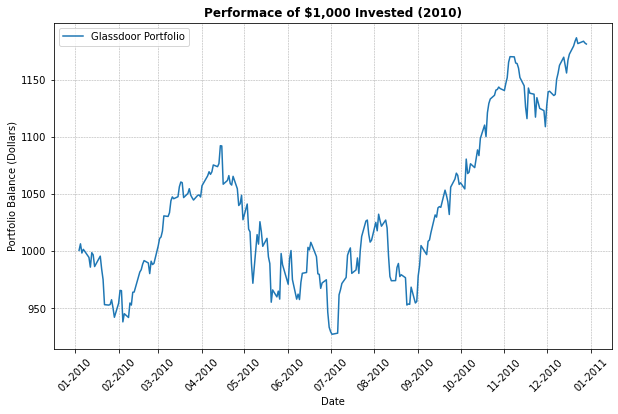

Stocks in 2010 Glassdoor Portfolio:

,stock_ticker
0,LUV
1,GIS
2,PG
3,JNPR
4,NATI
5,GOOG
6,NTAP
7,GS
8,FDS
9,MDT


Performance Evaluation: During 2010, the "Glassdoor" portfolio grew by 18.13%. No data for VOO ETF (S&P 500 index) for this year.

**Stock Performance Calculations for 2011:**

- FB: Data doesn't exist for startDate = 1293868800, endDate = 1325232000
- BCSF: Data doesn't exist for startDate = 1293868800, endDate = 1325232000


*NOTE: Insufficient information to build a portfolio for 2011. Was only able to sucessfully collect information on 4 stocks.*

**Stock Performance Calculations for 2012:**

- BCSF: Data doesn't exist for startDate = 1325404800, endDate = 1356854400
- RXT: Data doesn't exist for startDate = 1325404800, endDate = 1356854400
- DOW: Data doesn't exist for startDate = 1325404800, endDate = 1356854400


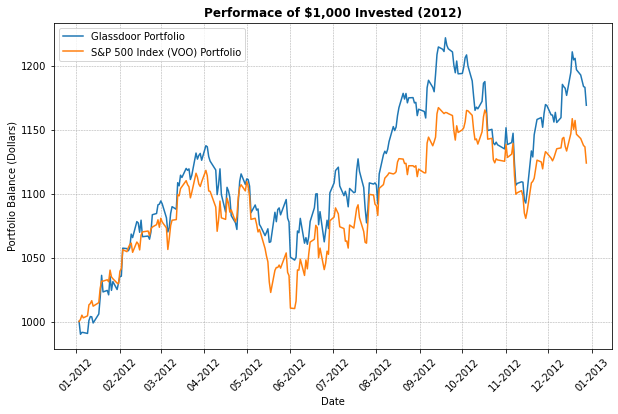

Stocks in 2012 Glassdoor Portfolio:

,stock_ticker
0,GOOG
1,AAPL
2,GIS
3,CRM
4,CVX
5,LUV
6,NATI


Performance Evaluation: During 2012, the "Glassdoor" portfolio grew by 16.94% compared to the S&P 500 index which grew by 12.43%.

**Stock Performance Calculations for 2013:**

- BCSF: Data doesn't exist for startDate = 1357027200, endDate = 1388390400
- RXT: Data doesn't exist for startDate = 1357027200, endDate = 1388390400
- SHEL: Data doesn't exist for startDate = 1357027200, endDate = 1388390400


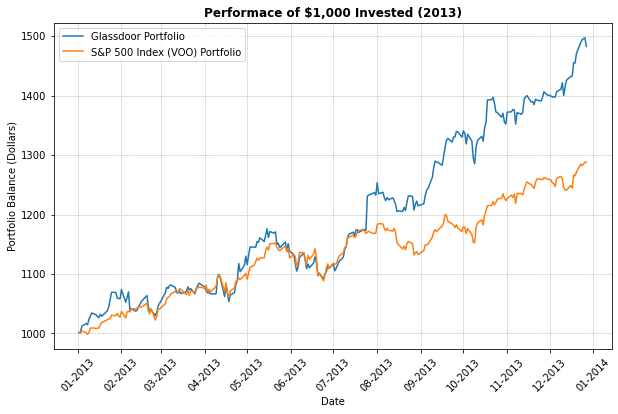

Stocks in 2013 Glassdoor Portfolio:

,stock_ticker
0,FB
1,GOOG
2,NATI
3,LUV
4,CVX
5,IT
6,AKAM


Performance Evaluation: During 2013, the "Glassdoor" portfolio grew by 48.24% compared to the S&P 500 index which grew by 28.79%.

**Stock Performance Calculations for 2014:**

- BCSF: Data doesn't exist for startDate = 1388563200, endDate = 1419926400


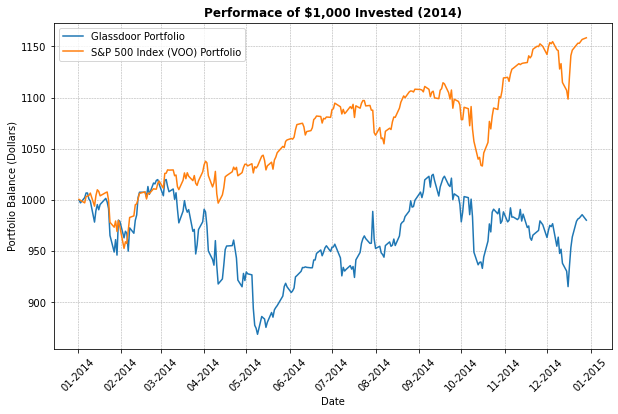

Stocks in 2014 Glassdoor Portfolio:

,stock_ticker
0,TWTR
1,KODK
2,FB
3,GWRE
4,GOOG
5,QCOM
6,CVX
7,COST


Performance Evaluation: During 2014, the "Glassdoor" portfolio fell by -1.97% compared to the S&P 500 index which grew by 15.85%.

**Stock Performance Calculations for 2015:**

- BCSF: Data doesn't exist for startDate = 1420099200, endDate = 1451462400


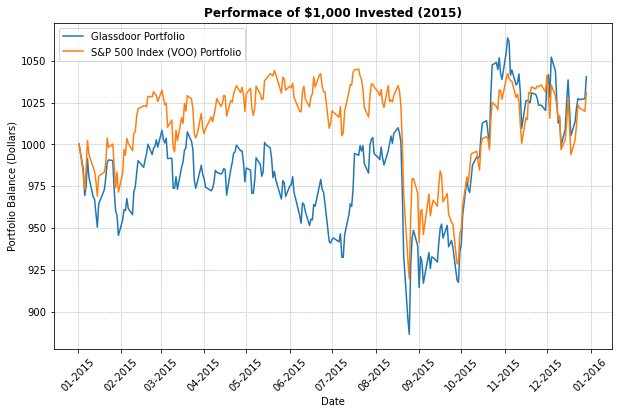

Stocks in 2015 Glassdoor Portfolio:

,stock_ticker
0,GOOG
1,FFIV
2,CVX
3,PG
4,FB
5,QCOM
6,LUV
7,ADBE


Performance Evaluation: During 2015, the "Glassdoor" portfolio grew by 4.04% compared to the S&P 500 index which grew by 3.12%.

**Stock Performance Calculations for 2016:**

- ABNB: Data doesn't exist for startDate = 1451635200, endDate = 1483084800
- BCSF: Data doesn't exist for startDate = 1451635200, endDate = 1483084800


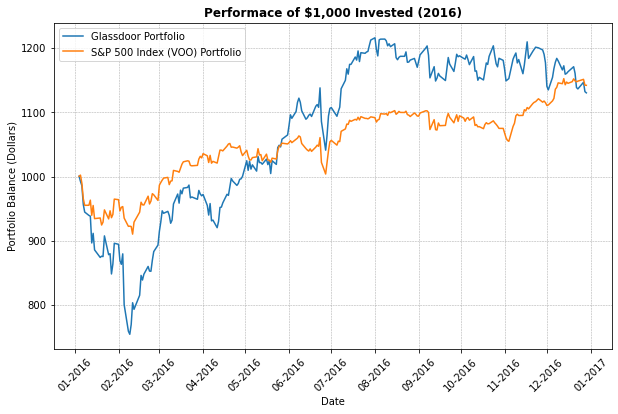

Stocks in 2016 Glassdoor Portfolio:

,stock_ticker
0,GWRE
1,HUBS
2,FB
3,GOOG
4,Z
5,KODK
6,EXPE


Performance Evaluation: During 2016, the "Glassdoor" portfolio grew by 13.05% compared to the S&P 500 index which grew by 14.22%.

**Stock Performance Calculations for 2017:**

- BCSF: Data doesn't exist for startDate = 1483257600, endDate = 1514620800


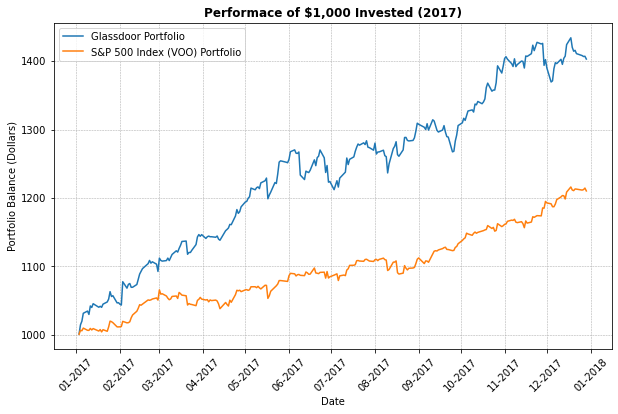

Stocks in 2017 Glassdoor Portfolio:

,stock_ticker
0,FB
1,GOOG
2,ADBE
3,CLX
4,PCTY
5,SAP
6,CRM
7,FORR


Performance Evaluation: During 2017, the "Glassdoor" portfolio grew by 40.29% compared to the S&P 500 index which grew by 21.02%.

**Stock Performance Calculations for 2018:**

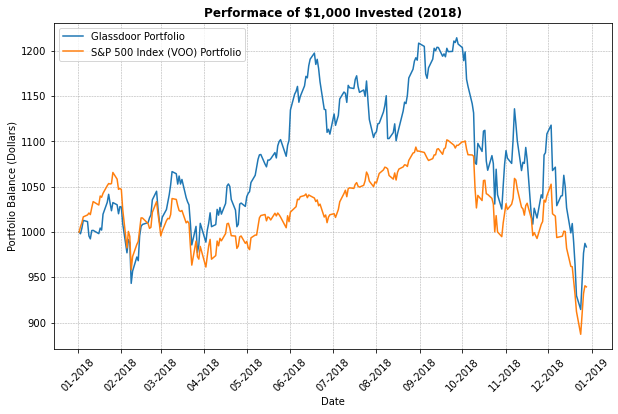

Stocks in 2018 Glassdoor Portfolio:

,stock_ticker
0,FB
1,GOOG
2,LULU
3,HUBS
4,SAP
5,ELF
6,CRM
7,DAL


Performance Evaluation: During 2018, the "Glassdoor" portfolio fell by -1.65% compared to the S&P 500 index which fell by -6.06%.

**Stock Performance Calculations for 2019:**

- PCOR: Data doesn't exist for startDate = 1546329600, endDate = 1577692800


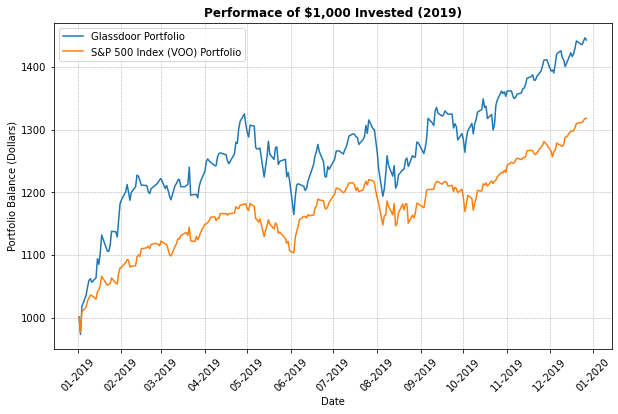

Stocks in 2019 Glassdoor Portfolio:

,stock_ticker
0,BCSF
1,FB
2,GOOG
3,LULU
4,LUV
5,CRM
6,HUBS
7,DOCU


Performance Evaluation: During 2019, the "Glassdoor" portfolio grew by 44.3% compared to the S&P 500 index which grew by 31.8%.

**Stock Performance Calculations for 2020:**

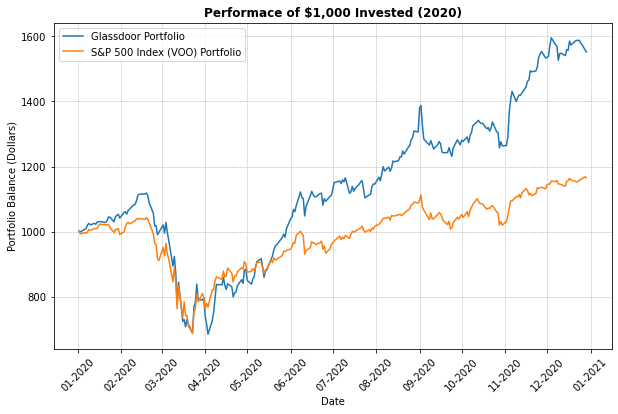

Stocks in 2020 Glassdoor Portfolio:

,stock_ticker
0,HUBS
1,BCSF
2,DOCU
3,LUV
4,GOOG


Performance Evaluation: During 2020, the "Glassdoor" portfolio grew by 55.23% compared to the S&P 500 index which grew by 16.6%.

**Stock Performance Calculations for 2021:**

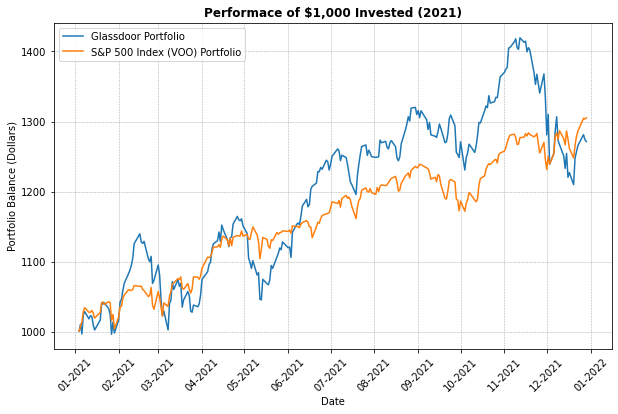

Stocks in 2021 Glassdoor Portfolio:

,stock_ticker
0,BCSF
1,NVDA
2,HUBS
3,GOOG
4,DAL
5,LULU
6,MSFT
7,FB
8,SYK
9,DOCU


Performance Evaluation: During 2021, the "Glassdoor" portfolio grew by 27.16% compared to the S&P 500 index which grew by 30.53%.

In [28]:
# Crunch the numbers and display results.
for yr in merged_df['year'].unique():
    try:
        year = str(yr)
        print()
        printmd(f'**Stock Performance Calculations for {year}:**')
        annual = gen_perf_df(year)
        stocks = [i for i in annual.columns if i.isupper() and i != 'VOO']
        # only analyze if we have information on 5+ companies. less than this is insufficient information for valid analysis 
        if len(stocks) >= 5:
            # Display line chart showing portfolio performance
            gen_chart(annual) 
            # Display list of stocks for given year 
            printmd(f'Stocks in {year} Glassdoor Portfolio:')
            display(pd.DataFrame(stocks, columns =['stock_ticker']))
            try:
                portf_res = annual[['date','portfolio_balance_s&p500','portfolio_balance_glassdoor']].tail(1)
            except KeyError:
                portf_res = annual[['date','portfolio_balance_glassdoor']].tail(1)
            try:
                # Obtain portfolio ending balances for glasdoor and s&p 500
                gd_endbal = portf_res.iloc[0]['portfolio_balance_glassdoor']
                sp_endbal = portf_res.iloc[0]['portfolio_balance_s&p500']
                # Calculate percentage change
                gd_pct = get_pct_change(1000, gd_endbal)
                sp_pct = get_pct_change(1000, sp_endbal)
                # Display a briefing
                printmd(f'Performance Evaluation: During {year}, the "Glassdoor" portfolio {verb(gd_pct)} by {str(gd_pct)}% compared to the S&P 500 index which {verb(sp_pct)} by {str(sp_pct)}%.')
            except KeyError:
                # Obtain portfolio ending balances for glasdoor and s&p 500
                gd_endbal = portf_res.iloc[0]['portfolio_balance_glassdoor']
                # Calculate percentage change
                gd_pct = get_pct_change(1000, gd_endbal)
                # Display a briefing
                printmd(f'Performance Evaluation: During {year}, the "Glassdoor" portfolio {verb(gd_pct)} by {str(gd_pct)}%. No data for VOO ETF (S&P 500 index) for this year.')
                pass
        else:
            printmd(f'*NOTE: Insufficient information to build a portfolio for {year}. Was only able to sucessfully collect information on {len(stocks)} stocks.*')
    except Exception as e:
        print(e)
        pass

## Conclusion
In reviewing the data above, we don't have sufficient stock data to draw mainingful conclusions upon prior to 2012. Since then however, our hypothetical portfolio of stock in Glassdoor's top rated companies has outperformed the S&P 500 for 7 of the 10 years during the period 2012-2021. We also saw that a large proportion of these companies are technology companies which is a sector that has performed better than most the last several years.